In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/unet-model/unet_5_iter_binary_loss.h5
/kaggle/input/carvana-image-masking-challenge/train_hq.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip


In [2]:
import zipfile
from skimage.util import random_noise

In [3]:
DATA_PATH = '../input/carvana-image-masking-challenge/'
# Will unzip the files so that you can see them..
with zipfile.ZipFile(DATA_PATH + "train_masks.csv.zip","r") as z:
    z.extractall(".")

In [4]:
# Will unzip the files so that you can see them..
with zipfile.ZipFile(DATA_PATH + "train.zip","r") as z:
    z.extractall(".")

In [5]:
# Will unzip the files so that you can see them..
with zipfile.ZipFile(DATA_PATH + "train_masks.zip","r") as z:
    z.extractall(".")

In [6]:
import os 
from glob import glob

INPUT_PATH = '.'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
# TEST_DATA = os.path.join(DATA_PATH, "test")
# TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
# METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")

# TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
# METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)

In [7]:
# random module is imported 
import random

random.seed(33)

train_files = np.array(glob(os.path.join(TRAIN_DATA, "*.jpg")))
train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in train_files])

size_ = len(train_ids)
indices = np.random.permutation(size_)

train_indices = indices[:int(0.8*size_)]
# train_indices = indices[:500]
test_indices = indices[int(0.8*size_):]

In [8]:
train_files, train_ids, test_files, test_ids = train_files[train_indices], train_ids[train_indices], train_files[test_indices], train_ids[test_indices]

In [9]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [10]:
image_size = (128,128)

In [11]:
import cv2
from PIL import Image

def mean_shift(input_img):
    # Shape of original image
    originShape = input_img.shape
    # Converting image into array of dimension [nb of pixels in originImage, 3]
    # based on r g b intensities    
    flatImg=np.reshape(input_img, [-1, 3])


    # Estimate bandwidth for meanshift algorithm    
    bandwidth = estimate_bandwidth(flatImg, quantile=0.1, n_samples=50)    
    ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)

    # Performing meanshift on flatImg    
    ms.fit(flatImg)

    # (r,g,b) vectors corresponding to the different clusters after meanshift    
    labels=ms.labels_
    
    # Remaining colors after meanshift    
    cluster_centers = ms.cluster_centers_    

    # Finding and diplaying the number of clusters    
    labels_unique = np.unique(labels)    
    n_clusters_ = len(labels_unique)
    
    return np.reshape(labels, (*input_img.shape[:2], 1))


def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if True:
        img = cv2.resize(img, image_size)
        # Add salt-and-pepper noise to the image.
#         img = random_noise(img, mode='s&p',amount=0.2)
    return img/np.max(img)


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)
    if True:
#         img_pil = img_pil.resize((388, 388))
        img_pil = img_pil.resize(image_size)
    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

In [12]:
import matplotlib.pylab as plt

In [13]:
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

import tensorflow as tf

%matplotlib inline

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1, 
                 shuffle=True, image_type='Train', mask_image_type='Train_mask'):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.image_type = image_type
        self.mask_image_type = mask_image_type
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim))
#         y = np.empty((self.batch_size, 388, 388))
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = get_image_data(ID, self.image_type)
            y[i,] = get_image_data(ID, self.mask_image_type)
        
        return X, y

In [15]:
# Parameters
params = {'dim': image_size,
          'batch_size': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(train_ids, **params)
validation_generator = DataGenerator(test_ids, **params)

In [23]:
def unet(input_img):
    # padding = 0 , stride = 1
    # input image = 576*576
    c1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(input_img) #576*576
    c2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(c1) # 576*576
    mp1 = MaxPool2D(pool_size=(2,2))(c2) # 288*288
    c3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(mp1) # 288*288
    c4 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(c3) # 288*288
    mp2 = MaxPool2D(pool_size=(2,2))(c4) # 144*144
    c5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(mp2) # 144*144
    c6 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(c5) # 144*144
    mp3 = MaxPool2D(pool_size=(2,2))(c6) # 72*72
    c7 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(mp3) # 72*72
    c8 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(c7) # 72*72
    mp4 = MaxPool2D(pool_size=(2,2))(c8) # 36*36
    dr1 = Dropout(rate=0.3)(mp4)
    c9 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same')(dr1) # 36*36
    c10 = Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same')(c9) # 36*36
    
    #upsampling followed by a 2x2 convolution
#     up1 = UpSampling2D(size=(2,2))(c10) # 56*56
    # up convolve
    up1 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='valid', activation='relu')(c10)    # 72*72 concatenate c8
    merge1 = concatenate([c8, up1]) # 72*72
    c11 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(merge1) # 72*72
    c12 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(c11) # 72*72
#     up2 = UpSampling2D(size=(2,2))(c12) # 104*104
    up2 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='valid', activation='relu')(c12) # 144*144

    # concatenate c6
    merge2 = concatenate([c6, up2]) # 144*144
    c13 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(merge2) # 144*144
    c14 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(c13) # 144*144
    up3 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='valid', activation='relu')(c14) # 288*288
#     # concatenate c4
    merge3 = concatenate([c4, up3])
    c15 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(merge3) # 288*288
    c16 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(c15) # 288*288
    up4 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='valid', activation='relu')(c16) # 576*576
#     # conctenate c2
    merge4 = concatenate([c2, up4]) # 576*576
    c17 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(merge4) # 576*576
    c18 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(c17) # 576*576
    # filters here need to be the nu,ber of classes
    c19 = Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(c18) # 576*576
    
    return c19

In [24]:
input_img = Input(shape = (*params['dim'], params['n_channels']))

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return (numerator + 1) / (denominator + 1)

autoencoder = Model(input_img, unet(input_img))
autoencoder.compile(loss=keras.losses.binary_crossentropy, metrics=[dice_loss, keras.losses.binary_crossentropy], optimizer='adam')
# autoencoder.compile(loss=keras.losses.binary_crossentropy, optimizer='adam')

In [25]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [26]:
autoencoder_train = autoencoder.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=1, epochs=5)

Train for 2035 steps, validate for 509 steps
Epoch 1/5
2035/2035 [==============================] - 206s 101ms/step - loss: 0.0676 - dice_loss: 0.8717 - binary_crossentropy: 0.0676 - val_loss: 0.0209 - val_dice_loss: 0.9683 - val_binary_crossentropy: 0.0209
Epoch 2/5
2035/2035 [==============================] - 203s 100ms/step - loss: 0.0271 - dice_loss: 0.9541 - binary_crossentropy: 0.0271 - val_loss: 0.0280 - val_dice_loss: 0.9336 - val_binary_crossentropy: 0.0280
Epoch 3/5
2035/2035 [==============================] - 201s 99ms/step - loss: 0.0188 - dice_loss: 0.9655 - binary_crossentropy: 0.0188 - val_loss: 0.0183 - val_dice_loss: 0.9666 - val_binary_crossentropy: 0.0183
Epoch 4/5
2035/2035 [==============================] - 204s 100ms/step - loss: 0.0170 - dice_loss: 0.9689 - binary_crossentropy: 0.0170 - val_loss: 0.0129 - val_dice_loss: 0.9770 - val_binary_crossentropy: 0.0129
Epoch 5/5
2035/2035 [==============================] - 204s 100ms/step - loss: 0.0113 - dice_loss: 0.978

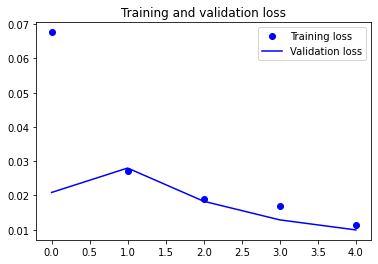

In [27]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_ = range(5)
plt.figure()
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
imgs = validation_generator.__getitem__(15)

In [29]:
training_images = imgs[0]
testing_images = imgs[1]

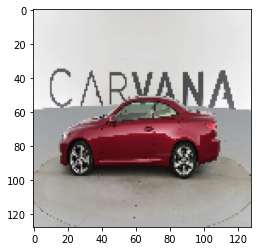

In [30]:
plt.imshow(training_images[0])

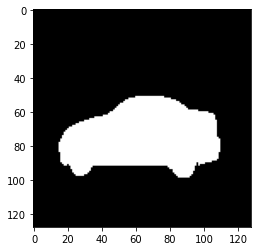

In [31]:
plt.imshow(testing_images[0], cmap='gray')

In [32]:
testing_images[0].shape

(128, 128)

In [33]:
pred = autoencoder.predict(training_images)

In [34]:
pred.shape

(2, 128, 128, 1)

In [35]:
plt.imshow(pred[1].reshape(128,128), cmap='gray')

ValueError: cannot reshape array of size 16384 into shape (576,576)

In [ ]:
autoencoder.save('unet_5_iter_binary_loss.h5')

In [ ]:
# load model
model = load_model('../input/unet-model/unet_5_iter_binary_loss.h5')

In [ ]:
pred = model.predict(training_images)

In [ ]:
plt.imshow(pred[0].reshape(388,388), cmap='gray')

In [ ]:
ae_2 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=1, epochs=5)

In [ ]:
pred = model.predict(training_images)
plt.imshow(pred[0].reshape(388,388), cmap='gray')

In [ ]:
model.save('unet_multi_iter_binary_loss.h5')